# Movie Recommendation System

## Business Problem

[Letterboxd](https://letterboxd.com/) is a social media platform designed for users to track the movies they've watched, allowing them to quickly access their favorite films and share them with friends.

While the platform emphasizes film sharing and community interaction, it currently lacks a built-in movie recommendation system. Instead, recommendations are driven by the user's social connections and interactions within the platform. This community-based approach, though personal, means users without friends on Letterboxd miss out on receiving new recommendations. 

Introducing a recommendation system that leverages users' viewing and rating history could enhance the platform's value.

## Data Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. 

It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

## Import Packages and Data

In [185]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from surprise import Reader, Dataset, NormalPredictor, BaselineOnly, accuracy, CoClustering, SlopeOne
from surprise.model_selection import train_test_split as surprise_train_test_split, cross_validate, GridSearchCV as surprise_GridSearchCV
from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline, KNNWithZScore
from surprise.model_selection import GridSearchCV

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from src.classes import FeatureEngineering

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import pickle

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Import data
links_df = pd.read_csv("data/links.csv")
movies_df = pd.read_csv("data/movies.csv")
ratings_df = pd.read_csv("data/ratings.csv")
tags_df = pd.read_csv("data/tags.csv")

In [3]:
# Set a global random seed
np.random.seed(19)
random.seed(19)

# Exploratory Data Analysis

## Data Investigation

### Column Cleaning

In [4]:
# Define a function to rename the columns
def rename_columns(df):
    df.columns = df.columns.str.replace('([A-Z])', r'_\1', regex=True).str.lower()
    return df

# List of DataFrames
dfs = [links_df, movies_df, ratings_df, tags_df]

# Apply the renaming function to each DataFrame
for df in dfs:
    rename_columns(df)

### Check for Missingness

In [5]:
# Check for missing values
names = ['links_df', 'movies_df', 'ratings_df', 'tags_df']

for name, df in zip(names, dfs):
    print(f"{name} missing values:")
    print(f"Length of DataFrame: {len(df)}")
    print(df.isna().sum())
    print()

links_df missing values:
Length of DataFrame: 9742
movie_id    0
imdb_id     0
tmdb_id     8
dtype: int64

movies_df missing values:
Length of DataFrame: 9742
movie_id    0
title       0
genres      0
dtype: int64

ratings_df missing values:
Length of DataFrame: 100836
user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

tags_df missing values:
Length of DataFrame: 3683
user_id      0
movie_id     0
tag          0
timestamp    0
dtype: int64



There is explicit missingness inside of the links_df in the tmdb_id column. However, this is not meaningful and can be ignored. 

The focus of the recommendation systems training will center on the movies_df and the ratings_df. As such, let's see if there is any hidden missingness in either DataFrame. 

#### Movies DataFrame

In [6]:
# Investigate DataFrame
no_genre_movies = movies_df[movies_df['genres'] == '(no genres listed)']
no_genre_movies.head()


,movie_id,title,genres
8517,114335,La cravate (1957),(no genres listed)
8684,122888,Ben-hur (2016),(no genres listed)
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
8782,129250,Superfast! (2015),(no genres listed)
8836,132084,Let It Be Me (1995),(no genres listed)


So there are entries that are labeled as '(no genres listed)'. We will want to drop these entries from the dataset.

In [7]:
# Determine data loss from dropping unknown data
no_genres_movies = movies_df[movies_df['genres'] == '(no genres listed)']

print(f"Count of no genre movies: {len(no_genres_movies)}")
print(f"Count of all movies: {len(movies_df)}")
print(f"Percent of movies dropped: {len(no_genres_movies) / len(movies_df)* 100:.2f}%")

Count of no genre movies: 34
Count of all movies: 9742
Percent of movies dropped: 0.35%


In [8]:
# Filter out these movies from the DataFrame
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']

In [9]:
# Show trimmed DataFrame
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9708 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  9708 non-null   int64 
 1   title     9708 non-null   object
 2   genres    9708 non-null   object
dtypes: int64(1), object(2)
memory usage: 303.4+ KB


#### Ratings DataFrame

In [10]:
# Investigate DataFrame
ratings_df['rating'].value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

There is no missingness inside of the ratings portion of the ratings DataFrame. 

## DataFrame Metrics

### Movies DataFrame

In [11]:
# Split the genres by '|' and create a binary matrix
genres_expanded = movies_df['genres'].str.get_dummies(sep='|')

In [12]:
# Concatenate the original DataFrame with the new binary genre columns
movies_df_with_genres = pd.concat([movies_df, genres_expanded], axis=1)

In [13]:
# Drop the original 'genres' column if no longer needed
movies_df_with_genres = movies_df_with_genres.drop('genres', axis=1)

In [14]:
# Calculate the frequency of each genre
genre_counts = genres_expanded.sum()

# Sort genres by frequency in descending order
genre_counts_sorted = genre_counts.sort_values(ascending=False)

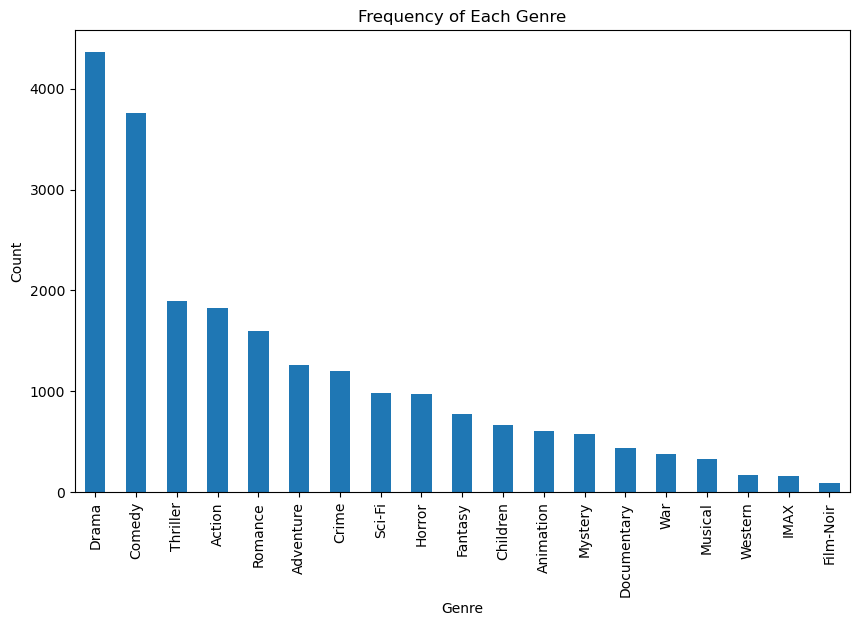

In [15]:
# Plotting
plt.figure(figsize=(10, 6))
genre_counts_sorted.plot(kind='bar')
plt.title('Frequency of Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

### Ratings DataFrame

In [16]:
# Calculate the frequency of each rating
ratings_counts = ratings_df['rating'].value_counts()

# Sort genres by frequency in descending order
ratings_counts_sorted = ratings_counts.sort_values(ascending=False)

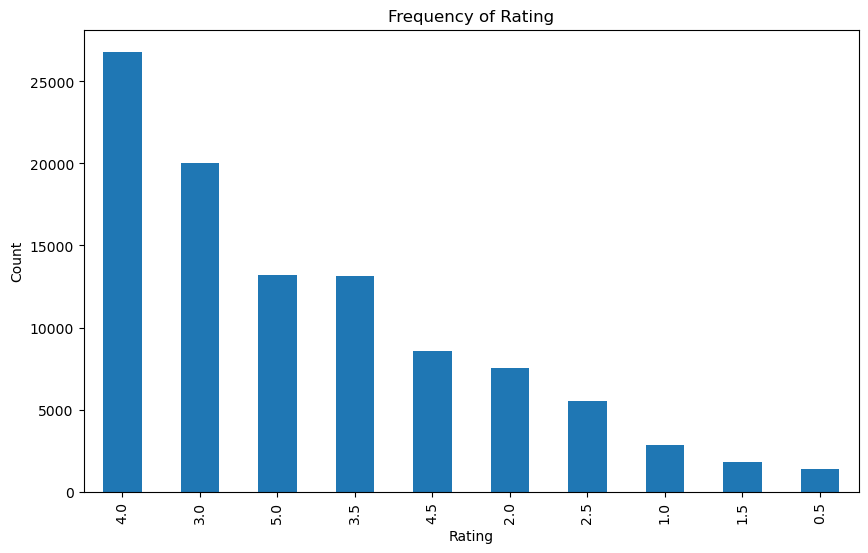

In [17]:
# Plotting
plt.figure(figsize=(10, 6))
ratings_counts_sorted.plot(kind='bar')
plt.title('Frequency of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Collaborative Filtering Models

For the models (where applicable) they will use user-based approaches as the goal is to offer recommendations to users based on their preferences. 

In [18]:
# Create a log dictionary
collab_models_log = {}

In [19]:
# Create DataFrame for analysis
collab_filter_df = ratings_df.drop(['timestamp'],axis=1)

## Establish Surprise Data Set

In [20]:
# Read in values as Surprise dataset 
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(collab_filter_df,reader)

# Extract DataFrame tuples from Dataset Object
raw_ratings = data.raw_ratings

In [21]:
# Shuffle the tuples
random.shuffle(raw_ratings)

In [22]:
# train_ratings (trainset) = 75% of the data, test_ratings (testset) = 25% of the data
threshold = int(0.75 * len(raw_ratings))
train_data = raw_ratings[:threshold]
test_data = raw_ratings[threshold:]

In [23]:
# Set the Surprise Dataset equal to A_raw_ratings
data.raw_ratings = train_data

In [24]:
# Rename data variable for readability
data_train = data

### Create Tuning and Evaluation Function

In [25]:
def surprise_tune_and_evaluate(model, param_grid, model_name):
    # Set up GridSearchCV
    gs = surprise_GridSearchCV(model, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
    gs.fit(data_train)
    
    # Get the best model and parameters
    best_model = gs.best_estimator['rmse']

    # Train on the entire trainset
    trainset = data_train.build_full_trainset()
    best_model.fit(trainset)
    
    # Calculate the RMSE score for the trainset
    print('Trainset Results')
    predictions_trainset = best_model.test(trainset.build_testset())
    rmse_train = round(accuracy.rmse(predictions_trainset), 5)

    # Fit the best model on the holdout test
    print('Testset Results')
    testset = data_train.construct_testset(test_data) # Converts data_train from train to test data
    predictions_testset = best_model.test(testset)
    rmse_test = round(accuracy.rmse(predictions_testset), 5)

    # Log RMSE
    collab_models_log[model_name] = {
        "Train RMSE": rmse_train,
        "Test RMSE": rmse_test
    }
    
    return best_model

## Establish SkLearn Data Set

## NormalPredictor Model

This model serves as a simple baseline to see how much better other models perform compared to a random guess.

In [26]:
# Instantiate the model
normal_predictor = NormalPredictor()

In [27]:
# Evaluate the model
results_normal_predictor = cross_validate(normal_predictor, data, measures=['RMSE'], cv=5, verbose=False)

In [28]:
# Get RMSE score
rmse_normal_predictor = round(results_normal_predictor['test_rmse'].mean(), 5)

# Print RMSE
print(f"Mean RMSE for NormalPredictor: {rmse_normal_predictor}")

Mean RMSE for NormalPredictor: 1.43703


In [29]:
# Log the results
collab_models_log['Normal_Prediction'] = {
    "Train RMSE": rmse_normal_predictor,
    "Test RMSE": rmse_normal_predictor
}

## Baseline Model

This model combines user and item biases with a global average to predict ratings.

For example, suppose that we want a baseline estimate for the rating of the movie Titanic by user Joe. 
- The average rating over all movies is 3.7 stars.
- Titanic is better than an average movie, so it tends to be rated 0.5 stars above the average. 
- Joe is a critical user, who tends to rate 0.3 stars lower than the average. 
- The baseline estimate for Titanic’s rating by Joe would be 3.9 stars

In [30]:
# Define the parameter grid
param_grid_baseline = {
    'bsl_options': {
        'method': ['als', 'sgd'],
        'reg_i': [5, 10, 15],
        'reg_u': [5, 10, 15],
        'n_epochs': [5, 10, 20],
        'lr_all': [0.002, 0.005, 0.007]
    }
}

In [31]:
# Perform hyperparameter tuning and evaluation for the model
best_baseline_only_model = surprise_tune_and_evaluate(BaselineOnly, param_grid_baseline, 'BaselineOnly')

Estimating biases using als...
Trainset Results
RMSE: 0.8177
Testset Results
RMSE: 0.8661


## KNN Models

Below are variations of k-nearest neighbors (KNN) algorithms tailored for collaborative filtering in recommendation systems. 
- KNNBasic computes similarities between users and predicts ratings based on the average ratings of the most similar neighbors.
- KNNWithMeans enhances the KNNBasic strategy by considering the mean ratings of users and adjusting for user bias.
- KNNWithZScore further refines predictions by normalizing ratings using z-scores, addressing variations in users' rating scales.
- KNNBaseline incorporates baseline estimates, which take into account user biases, improving prediction accuracy by correcting for systematic differences in ratings.

In [32]:
param_grid_knn = {
    'k': [10, 20, 30, 40, 50],
    'min_k': [1, 2, 3, 4, 5],
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
        'user_based': [True],
    }
}

In [33]:
# Perform hyperparameter tuning and evaluation for each model
best_knn_basic_model = surprise_tune_and_evaluate(KNNBasic, param_grid_knn, 'KNNBasic')
best_knn_with_means_model = surprise_tune_and_evaluate(KNNWithMeans, param_grid_knn, 'KNNWithMeans')
best_knn_baseline_model  = surprise_tune_and_evaluate(KNNBaseline, param_grid_knn, 'KNNBaseline')
best_knn_with_zscore_model  = surprise_tune_and_evaluate(KNNWithZScore, param_grid_knn, 'KNNWithZScore')

Computing the msd similarity matrix...
Done computing similarity matrix.
Trainset Results
RMSE: 0.6958
Testset Results
RMSE: 0.9346
Computing the msd similarity matrix...
Done computing similarity matrix.
Trainset Results
RMSE: 0.7371
Testset Results
RMSE: 0.8925
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Trainset Results
RMSE: 0.4788
Testset Results
RMSE: 0.8611
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Es

## CoClustering Model

This algorithm iteratively assigns users and items to clusters, refines these assignments, and estimates ratings based on the average rating within each user-item cluster pair.

In [34]:
# Define the parameter grid
param_grid_coclustering = {
    'n_cltr_u': [3, 5, 7, 9],
    'n_cltr_i': [3, 5, 7, 9],
    'n_epochs': [10, 20, 30],
    'random_state': [19] 
}

In [35]:
# Perform hyperparameter tuning and evaluation for the model
best_coclustering_model  = surprise_tune_and_evaluate(CoClustering, param_grid_coclustering, 'CoClustering')

Trainset Results
RMSE: 0.8096
Testset Results
RMSE: 0.9448


## SlopeOne Model

This algorithm calculates the average difference between the ratings of pairs of items across all users and uses this average difference to predict unknown ratings. This approach allows SlopeOne to handle new items and users easily, as it does not require a model to be trained explicitly.

In [36]:
# Instantiate the model
slopeone = SlopeOne()

In [37]:
# Create trainset from the data_train dataset
trainset = data_train.build_full_trainset()

# Create testset from the data_train dataset
testset = data_train.construct_testset(test_data) # Converts data_train from train to test data

In [38]:
# Fit SlopeOne model on the training set
slopeone.fit(trainset)

In [39]:
# Calculate the RMSE score for the trainset
print('Trainset Results')
predictions_trainset = slopeone.test(trainset.build_testset())
rmse_train_slopeone = round(accuracy.rmse(predictions_trainset), 5)
print(f'Train RMSE: {rmse_train_slopeone}')

Trainset Results
RMSE: 0.5773
Train RMSE: 0.57733


In [40]:
# Predict on the testset for SlopeOne
print('Testset Results')
predictions_slopeone = slopeone.test(testset)
rmse_test_slopeone = round(accuracy.rmse(predictions_slopeone), 5)
print(f'Test RMSE: {rmse_test_slopeone}')

Testset Results
RMSE: 0.9047
Test RMSE: 0.90471


In [41]:
# Log RMSE
collab_models_log["SlopeOne"] = {
    "Train RMSE": rmse_train_slopeone,
    "Test RMSE": rmse_test_slopeone
}

## Matrix Factorization

## Funk's Single Value Decomposition Model

This matrix factorization technique decomposes the user-item interaction matrix into the product of two lower-dimensional matrices, representing latent factors of users and items. Each user and item is mapped to a latent space, capturing underlying preferences and characteristics. The model aims to minimize the difference between the predicted and actual ratings by iteratively updating these latent factors using gradient descent.

In [42]:
# Define the parameter grid
param_grid_svd = {
    'n_factors': [100, 150, 200],
    'n_epochs': [30, 40, 50],
    'lr_all': [0.005, 0.01, 0.02],
    'reg_all': [0.1, 0.2, 0.4]
}

In [43]:
# Perform hyperparameter tuning and evaluation for the model
best_svd_model = surprise_tune_and_evaluate(SVD, param_grid_svd, 'Funks_SVD')

Trainset Results
RMSE: 0.5319
Testset Results
RMSE: 0.8526


### Alternative Least Squares (ALS) Model

This matrix factorization technique works by factorizing the user-item interaction matrix into two lower-dimensional matrices, representing latent factors of users and items. It iteratively alternates between fixing one matrix and solving for the other using least squares optimization, hence the name "alternating" least squares.

In [44]:
# Initialize Spark session
spark = SparkSession.builder.appName("ALSExample").getOrCreate()

24/08/01 18:46:55 WARN Utils: Your hostname, Evans-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.0.0.243 instead (on interface en0)
24/08/01 18:46:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/01 18:46:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [45]:
# Convert to Spark DataFrame
collab_filter_spark_df = spark.createDataFrame(collab_filter_df)

In [46]:
# Split the data into training and testing sets
(train_data, test_data) = collab_filter_spark_df.randomSplit([0.75, 0.25], seed=19)

In [47]:
# Define ALS model
als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

In [48]:
# Define parameter grid for hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(als.rank, [10, 20, 30, 40])
              .addGrid(als.regParam, [0.01, 0.1, 1.0])
              .addGrid(als.maxIter, [10, 20, 30])
              .build())

In [49]:
# Define evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [50]:
# Define CrossValidator
cross_validator = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [51]:
# Fit ALS model
cv_model = cross_validator.fit(train_data)

24/08/01 18:47:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/01 18:47:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/08/01 18:47:06 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done

In [52]:
# Get best model
best_model_als = cv_model.bestModel

In [53]:
# Make predictions on the training data
train_predictions = best_model_als.transform(train_data)

In [54]:
# Calculate the RMSE on the training data
rmse_train_als = evaluator.evaluate(train_predictions)

In [55]:
# Predict on test data
predictions = best_model_als.transform(test_data)

In [56]:
# Evaluate RMSE on test data
rmse_test_als = round(evaluator.evaluate(predictions), 5)
print(f"Test RMSE: {rmse_test_als}")

Test RMSE: 0.88257


In [57]:
# Log model results
collab_models_log['ALS_factorization'] = {
    "Train RMSE": rmse_train_als,
    "Test RMSE": rmse_test_als
}

In [58]:
# Stop Spark session
spark.stop()

## Results

In [59]:
# Convert dictionary to DataFrame
collab_results_df = pd.DataFrame(collab_models_log).T
collab_results_df.reset_index(inplace=True)
collab_results_df.columns = ['Model', 'Train RMSE', 'Test RMSE']

# Sort the DataFrame
collab_results_df = collab_results_df.sort_values(by=['Test RMSE'])

collab_results_df

,Model,Train RMSE,Test RMSE
8,Funks_SVD,0.53185,0.85256
4,KNNBaseline,0.47878,0.86115
1,BaselineOnly,0.81766,0.86607
9,ALS_factorization,0.46742,0.88257
3,KNNWithMeans,0.73706,0.89247
5,KNNWithZScore,0.74071,0.89322
7,SlopeOne,0.57733,0.90471
2,KNNBasic,0.69580,0.93458
6,CoClustering,0.80962,0.94481
0,Normal_Prediction,1.43703,1.43703


# Boosting Models

For our prediction models, we will first use Funk's SVD (Singular Value Decomposition) to perform matrix factorization on the user-item rating data. This step will allow us to capture latent factors that represent underlying patterns in user preferences and item characteristics. The SVD model will generate initial predictions for user ratings.

Following this, we will compute the residuals, which are the differences between the actual ratings and the predictions made by the SVD model. These residuals represent the errors or inaccuracies in the initial predictions.

Then, to further optimize the prediction accuracy and reduce the RMSE, boosting models will be applied to these residuals. In doing so, the boosting models will focus on learning and correcting the errors made by the SVD model.

## Establish Residuals DataFrame

In [60]:
# Read in values as Surprise dataset 
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(collab_filter_df,reader)

# Predict on the entire dataset
full_dataset = data.build_full_trainset()
full_dataset_testset = full_dataset.build_testset()
svd_predictions_full_dataset = best_svd_model.test(full_dataset_testset)

In [61]:
# Convert predictions to a DataFrame
residual_svd_df = pd.DataFrame(svd_predictions_full_dataset, columns=['user_id', 'movie_id', 'true_r', 'est', 'details'])

# Calculate residuals
residual_svd_df['svd_residual'] = residual_svd_df['true_r'] - residual_svd_df['est']

residual_svd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       100836 non-null  int64  
 1   movie_id      100836 non-null  int64  
 2   true_r        100836 non-null  float64
 3   est           100836 non-null  float64
 4   details       100836 non-null  object 
 5   svd_residual  100836 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 4.6+ MB


In [62]:
# Convert predictions to a DataFrame
residual_svd_df = pd.DataFrame(svd_predictions_full_dataset, columns=['user_id', 'movie_id', 'true_r', 'est', 'details'])

# Calculate residuals
residual_svd_df['svd_residual'] = residual_svd_df['true_r'] - residual_svd_df['est']

residual_svd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       100836 non-null  int64  
 1   movie_id      100836 non-null  int64  
 2   true_r        100836 non-null  float64
 3   est           100836 non-null  float64
 4   details       100836 non-null  object 
 5   svd_residual  100836 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 4.6+ MB


### Merge in Genre Information

In [63]:
# Split genres into lists
movies_df.loc[:, 'genres'] = movies_df['genres'].str.split('|')

In [64]:
# One-hot encode genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies_df['genres'])

In [65]:
# Create a DataFrame for the one-hot encoded genres
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=movies_df.index)

In [66]:
# Drop the original genres column as it's no longer needed
movies_df = movies_df.drop(columns=['genres'])

# Merge one-hot encoded genres with original movies_df
movies_df = pd.concat([movies_df, genres_df], axis=1)

In [67]:
# Merge expanded genres to the ratings
residual_svd_df = pd.merge(residual_svd_df, movies_df, how='inner', on='movie_id')

residual_svd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100789 entries, 0 to 100788
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       100789 non-null  int64  
 1   movie_id      100789 non-null  int64  
 2   true_r        100789 non-null  float64
 3   est           100789 non-null  float64
 4   details       100789 non-null  object 
 5   svd_residual  100789 non-null  float64
 6   title         100789 non-null  object 
 7   Action        100789 non-null  int64  
 8   Adventure     100789 non-null  int64  
 9   Animation     100789 non-null  int64  
 10  Children      100789 non-null  int64  
 11  Comedy        100789 non-null  int64  
 12  Crime         100789 non-null  int64  
 13  Documentary   100789 non-null  int64  
 14  Drama         100789 non-null  int64  
 15  Fantasy       100789 non-null  int64  
 16  Film-Noir     100789 non-null  int64  
 17  Horror        100789 non-null  int64  
 18  IMAX

### Boosting - Evaluate and Log Function

In [68]:
def boosting_eval_log(model, param_grid, X_train, X_test, model_name):
    # Set up GridSearchCV
    gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    gs.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = gs.best_estimator_

    # Evaluate the model on the training set
    y_train_pred = best_model.predict(X_train)
    rmse_train = round(mean_squared_error(y_train, y_train_pred, squared=False), 5)
    print(f'{model_name} Model Train RMSE: {rmse_train}')

    # Evaluate the model on the test set
    y_test_pred = best_model.predict(X_test)
    rmse_test = round(mean_squared_error(y_test, y_test_pred, squared=False), 5)
    print(f'{model_name} Model Test RMSE: {rmse_test}')

    # Log RMSE
    collab_models_log[model_name] = {
        "Train RMSE": rmse_train,
        "Test RMSE": rmse_test
    }

    return best_model

## Boosting without Feature Engineering

### Define Target and Train, Test, Split the Data

In [69]:
# Define target and features
X = residual_svd_df.drop(['svd_residual', 'user_id', 'movie_id', 'title', 'details', 'true_r'], axis=1)
y = residual_svd_df['svd_residual']

In [70]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19)

### AdaBoost

In [71]:
# Initialize AdaBoost with Decision Tree as the base estimator
base_estimator = DecisionTreeRegressor(max_depth=3)
ada = AdaBoostRegressor(base_estimator=base_estimator, random_state=19)

In [72]:
# Define parameter grid
param_grid_ada = {
    'base_estimator__max_depth': [1, 2, 3, 4, 5],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [73]:
# Evaluate the model
best_adaboost_model = boosting_eval_log(ada, param_grid_ada, X_train, X_test, 'AdaBoost_Funks_SVD')

/opt/anaconda3/envs/data_science_env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost_Funks_SVD Model Train RMSE: 0.59866
AdaBoost_Funks_SVD Model Test RMSE: 0.58762


### Gradient Boosting

In [74]:
# Instantiate the model
gbm = GradientBoostingRegressor(random_state=19)

In [75]:
# Define the parameter grid
param_grid_gbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 5],
    'subsample': [0.8, 0.9]
}

In [76]:
# Evaluate the model
best_gbm_boost_model = boosting_eval_log(gbm, param_grid_gbm, X_train, X_test, 'GBM_Funks_SVD')

GBM_Funks_SVD Model Train RMSE: 0.59405
GBM_Funks_SVD Model Test RMSE: 0.58624


### XGBoost

In [77]:
# Initialize the XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

In [78]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0.1, 0.2],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [1.5, 2]
}

In [79]:
# Evaluate the model
best_xgboost_model = boosting_eval_log(xgb, param_grid_xgb, X_train, X_test, 'XGBoost_Funks_SVD')

XGBoost_Funks_SVD Model Train RMSE: 0.59729
XGBoost_Funks_SVD Model Test RMSE: 0.58704


## Boosting with Feature Engineering

Lets see if we can improve our RMSE scores by adding in additional features which could aid the model in giving better recommendations. 

Lets add in the following:

- Moving Rating Count
- Average Movie Rating
- Average User Rating
- User Rating Count
- User-Movie Rating Count Ratio
- User Rating vs. Movie Average Rating Ratio

A pipeline will be used to ensure there is no data leakage as some of these features are aggregates. 

### Define Target and Train, Test, Split the Data

In [80]:
# Define target and features
X = residual_svd_df.drop(['svd_residual'], axis=1)
y = residual_svd_df['svd_residual']

In [81]:
# Perform Train Test Split
X_train_feat, X_test_feat, y_train, y_test = train_test_split(X, y, random_state=19)

#### Perform Feature Engineering via Pipeline

In [82]:
# Define and apply the feature engineering pipeline
pipeline_feature = Pipeline(steps=[
    ('feature_engineering', FeatureEngineering())
])

In [83]:
# Fit and transform the training data
X_train_transformed = pipeline_feature.fit_transform(X_train_feat)

# Transform the test data
X_test_transformed = pipeline_feature.transform(X_test_feat)

In [84]:
# Drop columns that are not needed for modeling
X_train_feat = X_train_transformed.drop(columns=['user_id', 'movie_id', 'title', 'details', 'true_r'])
X_test_feat = X_test_transformed.drop(columns=['user_id', 'movie_id', 'title', 'details', 'true_r'])

### Feature Engineering: AdaBoost

In [85]:
# Initialize AdaBoost with Decision Tree as the base estimator
base_estimator = DecisionTreeRegressor(max_depth=3)
feat_eng_ada = AdaBoostRegressor(base_estimator=base_estimator, random_state=19)

In [86]:
# Evaluate the model
best_feat_eng_adaboost_model = boosting_eval_log(feat_eng_ada, param_grid_ada, X_train_feat, X_test_feat, 'Feat_Eng_AdaBoost_Funks_SVD')

/opt/anaconda3/envs/data_science_env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Feat_Eng_AdaBoost_Funks_SVD Model Train RMSE: 0.58771
Feat_Eng_AdaBoost_Funks_SVD Model Test RMSE: 0.58417


### Feature Engineering: Gradient Boosting

In [87]:
# Instantiate the model
feat_eng_gbm = GradientBoostingRegressor(random_state=19)

In [88]:
# Define the parameter grid
param_grid_gbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 5],
    'subsample': [0.8, 0.9]
}

In [89]:
# Evaluate the model
best_feat_eng_gbm_boost_model = boosting_eval_log(feat_eng_gbm, param_grid_gbm, X_train_feat, X_test_feat, 'Feat_Eng_GBM_Funks_SVD')

Feat_Eng_GBM_Funks_SVD Model Train RMSE: 0.56452
Feat_Eng_GBM_Funks_SVD Model Test RMSE: 0.58304


### Feature Engineering: XGBoost 

In [90]:
# Initialize the XGBRegressor
feat_eng_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

In [91]:
# Evaluate the model
best__feat_eng_xgboost_model = boosting_eval_log(feat_eng_xgb, param_grid_xgb, X_train_feat, X_test_feat, 'Feat_Eng_XGBoost_Funks_SVD')

Feat_Eng_XGBoost_Funks_SVD Model Train RMSE: 0.56617
Feat_Eng_XGBoost_Funks_SVD Model Test RMSE: 0.58537


## Results

In [92]:
# Convert dictionary to DataFrame
collab_results_df = pd.DataFrame(collab_models_log).T
collab_results_df.reset_index(inplace=True)
collab_results_df.columns = ['Model', 'Train RMSE', 'Test RMSE']

# Sort the DataFrame
collab_results_df = collab_results_df.sort_values(by=['Test RMSE'])

collab_results_df

,Model,Train RMSE,Test RMSE
14,Feat_Eng_GBM_Funks_SVD,0.56452,0.58304
13,Feat_Eng_AdaBoost_Funks_SVD,0.58771,0.58417
15,Feat_Eng_XGBoost_Funks_SVD,0.56617,0.58537
11,GBM_Funks_SVD,0.59405,0.58624
12,XGBoost_Funks_SVD,0.59729,0.58704
10,AdaBoost_Funks_SVD,0.59866,0.58762
8,Funks_SVD,0.53185,0.85256
4,KNNBaseline,0.47878,0.86115
1,BaselineOnly,0.81766,0.86607
9,ALS_factorization,0.46742,0.88257


## Pickle the Models

In [93]:
# Define the path for the model file
svd_model_file_path = os.path.join('models', 'best_svd_model.pkl')

# Define the path for the model file
gbm_model_file_path = os.path.join('models', 'best_gbm_model.pkl')

# Define the path for the model file
feat_eng_gbm_model_file_path = os.path.join('models', 'best_feat_eng_gbm_model.pkl')

# Save the SVD model
with open(svd_model_file_path, 'wb') as file:
    pickle.dump(best_svd_model, file)

# Save the Gradient Boosting model
with open(gbm_model_file_path, 'wb') as file:
    pickle.dump(best_gbm_boost_model, file)

# Save the Gradient Boosting model with feature engineering
with open(feat_eng_gbm_model_file_path, 'wb') as file:
    pickle.dump(best_feat_eng_gbm_boost_model, file)

# Predictions

## Use Models to Create Predictions

In [94]:
# Load the best SVD model
with open('models/best_svd_model.pkl', 'rb') as f:
    best_svd_model = pickle.load(f)

# Load the best Gradient Boosting model
with open('models/best_gbm_model.pkl', 'rb') as f:
    best_gbm_model = pickle.load(f)

# Load the best Gradient Boosting model with feature engineering
with open('models/best_feat_eng_gbm_model.pkl', 'rb') as f:
    best_feat_eng_gbm_boost_model = pickle.load(f)

In [95]:
# Prepare user-movie pairs for prediction
unique_users = collab_filter_df['user_id'].unique()
unique_movies = movies_df['movie_id'].unique()
user_movie_pairs = pd.MultiIndex.from_product([unique_users, unique_movies], names=["user_id", "movie_id"]).to_frame(index=False)

In [96]:
# Create DataFrame which has rated movies
only_ratings_df = ratings_df.drop(['timestamp'], axis=1)

In [97]:
# Add ratings in to allow for predictions
ratings_user_movie_pairs = pd.merge(user_movie_pairs, only_ratings_df, how='left', on=['user_id', 'movie_id'])

In [98]:
# Read in values as Surprise dataset 
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_user_movie_pairs,reader)

# Predict on the entire dataset
full_dataset = data.build_full_trainset()
full_dataset_testset = full_dataset.build_testset()
svd_predictions_all_users = best_svd_model.test(full_dataset_testset)

In [99]:
# Convert predictions to a DataFrame
all_users_svd_df = pd.DataFrame(svd_predictions_all_users, columns=['user_id', 'movie_id', 'true_r', 'est', 'details'])

# Calculate residuals
all_users_svd_df['svd_residual'] = all_users_svd_df['true_r'] - all_users_svd_df['est']

all_users_svd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5921880 entries, 0 to 5921879
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   user_id       int64  
 1   movie_id      int64  
 2   true_r        float64
 3   est           float64
 4   details       object 
 5   svd_residual  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 271.1+ MB


In [100]:
all_users_svd_df.isna().sum()

user_id               0
movie_id              0
true_r          5821091
est                   0
details               0
svd_residual    5821091
dtype: int64

In [101]:
# Create predictions DataFrame for storing results
predictions_df = pd.merge(all_users_svd_df, movies_df, how='inner', on='movie_id')

### Without Feature Engineering

In [102]:
# Merge expanded genres to the ratings
gbm_preds_df = predictions_df.copy()

In [103]:
# Define target and features
X = gbm_preds_df.drop(['svd_residual'], axis=1)
y = gbm_preds_df['svd_residual']

In [104]:
# Drop columns that are not needed for modeling
X_final = X.drop(columns=['user_id', 'movie_id', 'title', 'details', 'true_r'])

In [106]:
# Predict with Gradient Boosted Model
gbm_all_users_predictions = best_gbm_model.predict(X_final)

In [107]:
# Add Gradient Boosted predictions to the DataFrame
predictions_df['gbm_est'] = gbm_all_users_predictions

In [108]:
# Combine SVD and Gradient Boosted predictions to get the final estimate
predictions_df['final_gbm_est'] = predictions_df['est'] + predictions_df['gbm_est']

### With Feature Engineering

In [109]:
# Merge expanded genres to the ratings
feat_gbm_preds_df =  pd.merge(all_users_svd_df, movies_df, how='inner', on='movie_id')

In [110]:
# Define target and features
X_feat = feat_gbm_preds_df.drop(['svd_residual'], axis=1)
y_feat = feat_gbm_preds_df['svd_residual']

In [112]:
# Define and apply the feature engineering pipeline
pipeline_feature = Pipeline(steps=[
    ('feature_engineering', FeatureEngineering())
])

In [113]:
# Fit and transform the training data
X_feat_transformed = pipeline_feature.fit_transform(X_feat)

In [114]:
# Drop columns that are not needed for modeling
X_feat_final = X_feat_transformed.drop(columns=['user_id', 'movie_id', 'title', 'details', 'true_r'])

In [116]:
# Predict with XGBoost model
feat_gbm_all_users_predictions = best_feat_eng_gbm_boost_model.predict(X_feat_final)

In [117]:
# Add XGBoost predictions to the DataFrame
predictions_df['feat_gbm_est'] = feat_gbm_all_users_predictions

In [118]:
# Combine SVD and XGBoost predictions to get the final estimate
predictions_df['final_feat_gbm_est'] = predictions_df['est'] + predictions_df['feat_gbm_est']

## Model Analysis

In [120]:
# See statistics behind the predictions
predictions_df[['est', 'final_gbm_est', 'final_feat_gbm_est']].describe()

,est,final_gbm_est,final_feat_gbm_est
count,5.921880e+06,5.921880e+06,5.921880e+06
mean,3.484339e+00,3.471676e+00,3.071014e+00
std,5.448733e-01,7.074871e-01,9.422435e-01
min,5.000000e-01,1.152976e-01,-7.199839e-01
25%,3.155062e+00,3.049548e+00,2.397350e+00
50%,3.523157e+00,3.534261e+00,3.161874e+00
75%,3.858538e+00,3.967082e+00,3.820455e+00
max,5.000000e+00,5.133068e+00,5.649403e+00


Range of Values:
- est (SVD Predictions): Ranges from 0.5 to 5.0, which is expected.
- xgb_est (XGBoost Predictions): Ranges from approximately -4.13 to 3.95, this is also expected as it is predicting the residuals from the SVD predictions.
- final_est: The range is from approximately -0.03 to 5.97. Given that we want the ratings to be inside of the range of the original ratings scale, the value should be scaled appropriately. 

## Scale the Final Predictions

In [122]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler(feature_range=(0.5, 5.0))

# Reshape data for scaler
final_est_reshaped = predictions_df['final_gbm_est'].values.reshape(-1, 1)

# Fit and transform
scaled_final_est = scaler.fit_transform(final_est_reshaped)

# Assign back to DataFrame
predictions_df['final_gbm_est'] = scaled_final_est


# Reshape data for scaler
final_feat_est_reshaped = predictions_df['final_feat_gbm_est'].values.reshape(-1, 1)

# Fit and transform
scaled_final_feat_est = scaler.fit_transform(final_feat_est_reshaped)

# Assign back to DataFrame
predictions_df['final_feat_gbm_est'] = scaled_final_feat_est

In [132]:
# Define user and number of films
user_id = 18
n = 15

In [150]:
def get_top_rated_movies(user_id, n=10):
    user_ratings = collab_filter_df[collab_filter_df['user_id'] == user_id]
    top_rated_movies = user_ratings.sort_values(by='rating', ascending=False).head(n)
    top_rated_movies = pd.merge(top_rated_movies, movies_df, on='movie_id')
    return top_rated_movies[['movie_id','title', 'rating']]

In [151]:
def get_top_n_recommendations_feat_gbm(user_id, n=10):
    # Filter for the specific user
    user_predictions = predictions_df[predictions_df['user_id'] == user_id]
    
    # Exclude movies already rated by the user
    rated_movies = collab_filter_df[collab_filter_df['user_id'] == user_id]['movie_id']
    user_predictions = user_predictions[~user_predictions['movie_id'].isin(rated_movies)]
    
    # Sort by the final predicted rating and get the top N
    top_n_recommendations = user_predictions.sort_values(by='final_feat_gbm_est', ascending=False).head(n)
    
    # Merge with movies_df to get movie titles
    top_n_recommendations = pd.merge(top_n_recommendations, movies_df, on='movie_id')
    
    return top_n_recommendations[['movie_id', 'title_x', 'final_feat_gbm_est']]

In [152]:
def get_top_n_recommendations_gbm(user_id, n=10):
    # Filter for the specific user
    user_predictions = predictions_df[predictions_df['user_id'] == user_id]
    
    # Exclude movies already rated by the user
    rated_movies = collab_filter_df[collab_filter_df['user_id'] == user_id]['movie_id']
    user_predictions = user_predictions[~user_predictions['movie_id'].isin(rated_movies)]
    
    # Sort by the final predicted rating and get the top N
    top_n_recommendations = user_predictions.sort_values(by='final_gbm_est', ascending=False).head(n)
    
    # Merge with movies_df to get movie titles
    top_n_recommendations = pd.merge(top_n_recommendations, movies_df, on='movie_id')
    
    return top_n_recommendations[['movie_id', 'title_x', 'final_gbm_est']]

In [153]:
def get_top_n_recommendations_svd(user_id, n=10):
    # Filter for the specific user
    user_predictions = predictions_df[predictions_df['user_id'] == user_id]
    
    # Exclude movies already rated by the user
    rated_movies = collab_filter_df[collab_filter_df['user_id'] == user_id]['movie_id']
    user_predictions = user_predictions[~user_predictions['movie_id'].isin(rated_movies)]
    
    # Sort by the final predicted rating and get the top N
    top_n_recommendations = user_predictions.sort_values(by='est', ascending=False).head(n)
    
    # Merge with movies_df to get movie titles
    top_n_recommendations = pd.merge(top_n_recommendations, movies_df, on='movie_id')
    
    return top_n_recommendations[['movie_id', 'title_x', 'est']]

In [154]:
get_top_rated_movies(user_id, n)

,movie_id,title,rating
0,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",5.0
1,1209,Once Upon a Time in the West (C'era una volta ...,5.0
2,318,"Shawshank Redemption, The (1994)",5.0
3,923,Citizen Kane (1941),5.0
4,50,"Usual Suspects, The (1995)",5.0
5,1221,"Godfather: Part II, The (1974)",5.0
6,1203,12 Angry Men (1957),5.0
7,3949,Requiem for a Dream (2000),4.5
8,2951,"Fistful of Dollars, A (Per un pugno di dollari...",4.5
9,112334,"Internet's Own Boy: The Story of Aaron Swartz,...",4.5


In [155]:
get_top_n_recommendations_feat_gbm(user_id, n)

,movie_id,title_x,final_feat_gbm_est
0,7121,Adam's Rib (1949),4.526704
1,951,His Girl Friday (1940),4.511854
2,27156,Neon Genesis Evangelion: The End of Evangelion...,4.506744
3,7842,Dune (2000),4.442427
4,2239,Swept Away (Travolti da un insolito destino ne...,4.434205
5,3224,Woman in the Dunes (Suna no onna) (1964),4.431611
6,3451,Guess Who's Coming to Dinner (1967),4.400638
7,1204,Lawrence of Arabia (1962),4.392130
8,6460,"Trial, The (Procès, Le) (1962)",4.385778
9,86377,Louis C.K.: Shameless (2007),4.378784


In [156]:
get_top_n_recommendations_gbm(user_id, n)

,movie_id,title_x,final_gbm_est
0,7121,Adam's Rib (1949),4.772293
1,951,His Girl Friday (1940),4.750892
2,27156,Neon Genesis Evangelion: The End of Evangelion...,4.738360
3,7842,Dune (2000),4.698536
4,3224,Woman in the Dunes (Suna no onna) (1964),4.686027
5,2239,Swept Away (Travolti da un insolito destino ne...,4.668229
6,3451,Guess Who's Coming to Dinner (1967),4.656755
7,6460,"Trial, The (Procès, Le) (1962)",4.642192
8,2677,Buena Vista Social Club (1999),4.639848
9,3468,"Hustler, The (1961)",4.630930


In [157]:
get_top_n_recommendations_svd(user_id, n)

,movie_id,title_x,est
0,27156,Neon Genesis Evangelion: The End of Evangelion...,4.564397
1,7121,Adam's Rib (1949),4.562820
2,951,His Girl Friday (1940),4.538957
3,7842,Dune (2000),4.525662
4,3224,Woman in the Dunes (Suna no onna) (1964),4.506609
5,3451,Guess Who's Coming to Dinner (1967),4.475041
6,1204,Lawrence of Arabia (1962),4.474735
7,1284,"Big Sleep, The (1946)",4.471588
8,2239,Swept Away (Travolti da un insolito destino ne...,4.463997
9,6460,"Trial, The (Procès, Le) (1962)",4.462136


Based on the predictions above, each models predictions seem to be in line with each other as they predict similar values for each film.

This similarity as well as proof that the model is making distinct predictions for each film gives confidence that the gradient boost SVD model is the best model. 

This will be the model used going forward to make predictions. 

# Predictions

In [2]:
def compute_similarity_matrix(predictions_df):
    # Select the movie features (genre columns)
    movie_features_df = predictions_df.drop(columns=['user_id', 'true_r', 'est', 'details', 'svd_residual', 
                                                     'title', 'gbm_est', 'final_gbm_est', 'feat_gbm_est'])
    
    feature_columns = movie_features_df.drop(['movie_id'], axis=1).columns

    # Normalize the features
    scaler = StandardScaler()
    movie_features_df[feature_columns] = scaler.fit_transform(movie_features_df[feature_columns])

    # Group by 'movie_id' and aggregate mean for each feature to avoid multiple rows for the same movie
    movie_features = movie_features_df.groupby('movie_id')[feature_columns].mean().reset_index()

    # Extract feature matrix for similarity calculation
    feature_matrix = movie_features[feature_columns].values

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(feature_matrix)

    # Convert to DataFrame for easier manipulation
    similarity_df = pd.DataFrame(similarity_matrix, index=movie_features['movie_id'], columns=movie_features['movie_id'])
    
    return similarity_df

In [3]:
def get_similar_movies(movie_id, similarity_df, n=3):
    # Get similarity scores for the given movie_id
    similarity_scores = similarity_df.loc[movie_id]

    # Get indices of the top N similar movies (excluding the movie itself)
    similar_movie_ids = similarity_scores.nlargest(n+1).iloc[1:].index.values

    return similar_movie_ids

In [4]:
def get_top_n_recommendations_feat_gbm(user_id, predictions_df, collab_filter_df, movies_df, n=10):
    # Filter for the specific user
    user_predictions = predictions_df[predictions_df['user_id'] == user_id]
    
    # Exclude movies already rated by the user
    rated_movies = collab_filter_df[collab_filter_df['user_id'] == user_id]['movie_id']
    user_predictions = user_predictions[~user_predictions['movie_id'].isin(rated_movies)]
    
    # Sort by the final predicted rating and get the top N
    top_n_recommendations = user_predictions.sort_values(by='final_feat_gbm_est', ascending=False).head(n)
    
    # Merge with movies_df to get movie titles
    top_n_recommendations = pd.merge(top_n_recommendations, movies_df, on='movie_id')
    
    return top_n_recommendations[['title_x', 'movie_id', 'final_feat_gbm_est']]

In [5]:
def get_recommendations_based_on_similarity(user_id, predictions_df, collab_filter_df, movies_df, similarity_df, top_n=10, n_similar=3):
    # Get the user's top N recommendations
    top_n_recommendations = get_top_n_recommendations_feat_gbm(user_id, predictions_df, collab_filter_df, movies_df, n=top_n)
    
    final_recommendations = []

    for _, row in top_n_recommendations.iterrows():
        top_movie_id = row['movie_id']
        top_movie_title = row['title_x']
        top_movie_rating = row['final_feat_gbm_est']
        
        # Get similar movies
        similar_movie_ids = get_similar_movies(top_movie_id, similarity_df, n=n_similar)
        
        for similar_movie_id in similar_movie_ids:
            similar_movie_title = movies_df[movies_df['movie_id'] == similar_movie_id]['title'].values[0]
            similarity_score = similarity_df.loc[top_movie_id, similar_movie_id]
            
            # Get the predicted rating for the similar movie
            similar_movie_rating = predictions_df[(predictions_df['movie_id'] == similar_movie_id) & 
                                                  (predictions_df['user_id'] == user_id)]['final_feat_gbm_est'].values[0]
            
            final_recommendations.append({
                'Top Rated Movie': top_movie_title,
                'Recommended Movie': similar_movie_title,
                'Similarity Score': similarity_score,
                'Predicted Rating': similar_movie_rating
            })
    
    # Create DataFrame from the recommendations list
    recommendations_df = pd.DataFrame(final_recommendations)
    
    # Maintain the order of top-rated movies and sort by predicted rating within each group
    recommendations_df = recommendations_df.sort_values(by=['Top Rated Movie', 'Predicted Rating'], ascending=[True, False]).reset_index(drop=True)
    
    return recommendations_df

In [6]:
# Compute similarity matrix once and reuse it for multiple recommendations
similarity_df = compute_similarity_matrix(predictions_df)

NameError: name 'predictions_df' is not defined

In [ ]:
# Set user_id for recommendations
user_id = 300
recommendations_df = get_recommendations_based_on_similarity(user_id, predictions_df, collab_filter_df, movies_df, similarity_df, top_n=10, n_similar=3)

In [7]:
recommendations_df

NameError: name 'recommendations_df' is not defined